<a href="https://colab.research.google.com/github/2303A52328/Explainable_AI/blob/main/Exp_ai_lab_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install libraries if needed (e.g., in Google Colab)
# !pip install pandas numpy scikit-learn matplotlib seaborn tensorflow shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn for Preprocessing and ML Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras.utils import to_categorical

# Explainable AI (XAI)
import shap
# from lime import lime_tabular # Need to install lime separately if using

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Start by loading your dataset ---
# Replace 'your_dataset.csv' with the actual file path or name
try:
    # df = pd.read_csv('/content/VeryMildImpairment (94).jpg') # This line caused the error
    # Alternatively, if the data is based on the image:
    df = pd.read_csv('brain_imaging_features_and_labels.csv')
except FileNotFoundError:
    print("Error: The file 'brain_imaging_features_and_labels.csv' was not found.")
    # Create dummy data for demonstration if the real data is unavailable
    print("Generating synthetic data for demonstration...")
    N = 1000
    df = pd.DataFrame({
        'Feature1': np.random.rand(N) * 10,
        'Feature2': np.random.randn(N) * 5,
        'Feature3_Cat': np.random.choice(['A', 'B', 'C'], N, p=[0.5, 0.3, 0.2]),
        'Feature4_Missing': np.random.choice([np.nan, 1, 2, 3], N, p=[0.1, 0.3, 0.3, 0.3]),
        'Target': np.random.randint(0, 2, N) # Assuming binary classification (0 or 1)
    })
    df['Target'] = ((df['Feature1'] > 5) & (df['Feature2'] > 0)).astype(int)
    # Re-check Target class imbalance
    df['Target'] = df['Target'].replace({1: 0, 0: 1}) # Making it imbalanced
    df.loc[df.sample(frac=0.1).index, 'Target'] = 1
    # Check class distribution:
    # print(df['Target'].value_counts())

print("Dataset loaded/generated successfully.")

Error: The file 'brain_imaging_features_and_labels.csv' was not found.
Generating synthetic data for demonstration...
Dataset loaded/generated successfully.


--- Part 1: EDA ---

Dataset Shape: (1000, 5)

Data Types and Missing Values (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Feature1          1000 non-null   float64
 1   Feature2          1000 non-null   float64
 2   Feature3_Cat      1000 non-null   object 
 3   Feature4_Missing  894 non-null    float64
 4   Target            1000 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 39.2+ KB

Missing Values Count:
Feature1              0
Feature2              0
Feature3_Cat          0
Feature4_Missing    106
Target                0
dtype: int64

Summary Statistics (df.describe()):
           Feature1     Feature2 Feature3_Cat  Feature4_Missing       Target
count   1000.000000  1000.000000         1000        894.000000  1000.000000
unique          NaN          NaN            3               NaN   

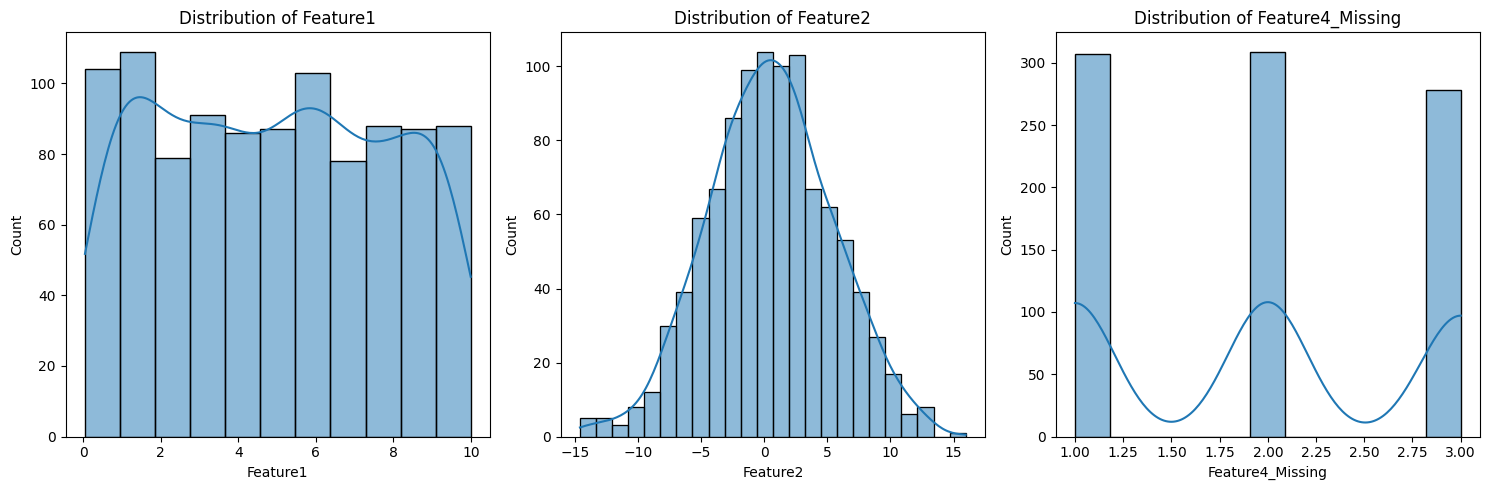

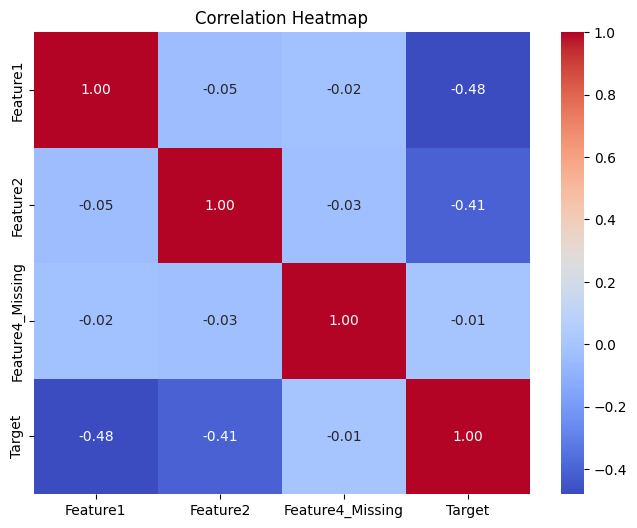


Target Variable: Target

Class Counts:
Target
1    765
0    235
Name: count, dtype: int64


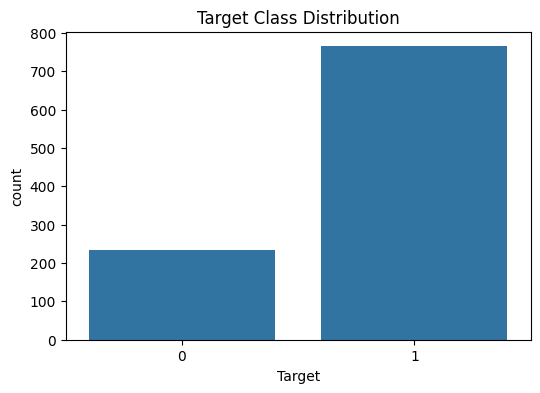


Class distribution appears relatively balanced.


In [3]:
## Part 1: Exploratory Data Analysis (EDA)

print("--- Part 1: EDA ---")

# 1. Inspect dataset shape, datatypes, and missing values
print("\nDataset Shape:", df.shape)
print("\nData Types and Missing Values (df.info()):")
df.info()

print("\nMissing Values Count:")
print(df.isnull().sum())

# 2. Generate summary statistics and visualize distributions
print("\nSummary Statistics (df.describe()):")
print(df.describe(include='all'))

# Visualize distributions (Numerical Features)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'Target' in numerical_features:
    numerical_features.remove('Target')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features[:3]): # Plot up to 3 for brevity
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 3. Plot a correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 4. Check class imbalance
target_col = 'Target' # Adjust if your target column name is different
print(f"\nTarget Variable: {target_col}")
class_counts = df[target_col].value_counts()
print("\nClass Counts:")
print(class_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Target Class Distribution')
plt.show()

# Imbalance check and recommendation (SMOTE/ADASYN)
minority_class_prop = class_counts.min() / class_counts.sum()
IMBALANCE_THRESHOLD = 0.15 # If the minority class is less than 15%
if minority_class_prop < IMBALANCE_THRESHOLD:
    print(f"\n⚠️ Significant Class Imbalance Detected! Minority class is {minority_class_prop:.2%}.")
    print("SMOTE or ADASYN will be recommended after splitting the data.")
else:
    print("\nClass distribution appears relatively balanced.")

# Identify features
features = [col for col in df.columns if col != target_col]
X = df[features]
y = df[target_col]

In [4]:
## Part 2: Data Preprocessing

print("\n--- Part 2: Data Preprocessing ---")

# 4. Split the dataset: 80% training, 20% testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train_raw.shape}, X_test shape: {X_test_raw.shape}")

# Identify feature types
numerical_cols = X_train_raw.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()

# Define transformers for different data types
# 3. Handle missing values appropriately (Imputation)
numerical_transformer = SimpleImputer(strategy='mean') # Mean for numerical

# 1. Encode categorical features (OneHotEncoder for nominal, LabelEncoder for ordinal/Target)
# Use 'most_frequent' for categorical imputation
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply imputation and encoding
# Fit the imputer/encoder on the training data ONLY

# Impute and Encode Categorical Features
if categorical_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_cat = imputer_cat.fit_transform(X_train_raw[categorical_cols])
    X_test_cat = imputer_cat.transform(X_test_raw[categorical_cols])

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train_cat)
    X_test_encoded = encoder.transform(X_test_cat)

    # Create feature names for the encoded columns
    feature_names = list(encoder.get_feature_names_out(categorical_cols))
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train_raw.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test_raw.index)
else:
    X_train_encoded = pd.DataFrame(index=X_train_raw.index)
    X_test_encoded = pd.DataFrame(index=X_test_raw.index)


# Impute Numerical Features
imputer_num = SimpleImputer(strategy='mean')
X_train_num = imputer_num.fit_transform(X_train_raw[numerical_cols])
X_test_num = imputer_num.transform(X_test_raw[numerical_cols])

X_train_num = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train_raw.index)
X_test_num = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test_raw.index)


# Concatenate Imputed/Encoded features
X_train_proc = pd.concat([X_train_num, X_train_encoded], axis=1)
X_test_proc = pd.concat([X_test_num, X_test_encoded], axis=1)


# 2. Scale numerical features (StandardScaler)
scaler = StandardScaler()
# Fit on numerical features only (which are now fully imputed in X_train_proc)
X_train_scaled = scaler.fit_transform(X_train_proc[numerical_cols])
X_test_scaled = scaler.transform(X_test_proc[numerical_cols])

# Recombine scaled numerical and encoded categorical features
X_train = X_train_proc.copy()
X_test = X_test_proc.copy()

X_train[numerical_cols] = X_train_scaled
X_test[numerical_cols] = X_test_scaled

print("\nFinal Preprocessing check (X_train):")
print(X_train.head())
print("Missing values after preprocessing:", X_train.isnull().sum().sum())

# Check class imbalance and apply SMOTE if needed (Only on training data)
minority_class_prop_train = y_train.value_counts().min() / y_train.shape[0]

if minority_class_prop_train < IMBALANCE_THRESHOLD:
    print("\nApplying SMOTE for Imbalance Correction...")
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    X_train = X_train_smote
    y_train = y_train_smote
    print(f"X_train shape after SMOTE: {X_train.shape}. New class distribution:\n{y_train.value_counts()}")
else:
    print("\nNo SMOTE applied.")


--- Part 2: Data Preprocessing ---
X_train shape: (800, 4), X_test shape: (200, 4)

Final Preprocessing check (X_train):
     Feature1  Feature2  Feature4_Missing  Feature3_Cat_A  Feature3_Cat_B  \
228  1.380296  0.932085          1.319330             0.0             1.0   
358  1.545860  0.474218          1.319330             1.0             0.0   
623 -0.019999  0.597308         -1.268795             1.0             0.0   
597 -1.092763  0.922315         -1.268795             1.0             0.0   
462  0.878619 -0.719764          0.025268             0.0             0.0   

     Feature3_Cat_C  
228             0.0  
358             0.0  
623             0.0  
597             0.0  
462             1.0  
Missing values after preprocessing: 0

No SMOTE applied.


In [5]:
## Part 3: Machine Learning Models

print("\n--- Part 3: Machine Learning Models ---")

# Setup for evaluation
model_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

def evaluate_model(model_name, y_true, y_pred, y_proba=None):
    """Calculates and stores evaluation metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    roc_auc = 'N/A'
    if y_proba is not None and len(np.unique(y_true)) == 2: # Only for binary classification
        roc_auc = roc_auc_score(y_true, y_proba[:, 1])

    global model_results
    model_results.loc[len(model_results)] = [model_name, acc, prec, rec, f1, roc_auc]

    print(f"✅ {model_name} completed.")
    return acc, f1

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True), # probability=True for ROC-AUC
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

best_ml_model_name = None
best_ml_f1 = 0

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    acc, f1 = evaluate_model(name, y_test, y_pred, y_proba)

    # Track the best model for XAI and later comparison
    if f1 > best_ml_f1:
        best_ml_f1 = f1
        best_ml_model = model
        best_ml_model_name = name

print("\n--- ML Model Comparison Table ---")
print(model_results.to_markdown(index=False, floatfmt=".4f"))


--- Part 3: Machine Learning Models ---
✅ Logistic Regression completed.
✅ Decision Tree completed.
✅ Random Forest completed.
✅ SVM completed.
✅ KNN completed.
✅ XGBoost completed.

--- ML Model Comparison Table ---
| Model               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:--------------------|-----------:|------------:|---------:|-----------:|----------:|
| Logistic Regression |     0.8900 |      0.8868 |   0.8900 |     0.8852 |    0.9385 |
| Decision Tree       |     0.9450 |      0.9443 |   0.9450 |     0.9444 |    0.9125 |
| Random Forest       |     0.9550 |      0.9580 |   0.9550 |     0.9558 |    0.9766 |
| SVM                 |     0.9300 |      0.9292 |   0.9300 |     0.9295 |    0.9704 |
| KNN                 |     0.9300 |      0.9312 |   0.9300 |     0.9305 |    0.9625 |
| XGBoost             |     0.9550 |      0.9580 |   0.9550 |     0.9558 |    0.9701 |



--- Part 4: Deep Learning Models ---

Training MLP Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
✅ MLP Model Evaluation: Accuracy=0.9350, F1-Score=0.9361

--- Confusion Matrix (MLP) ---
[[ 43   4]
 [  9 144]]


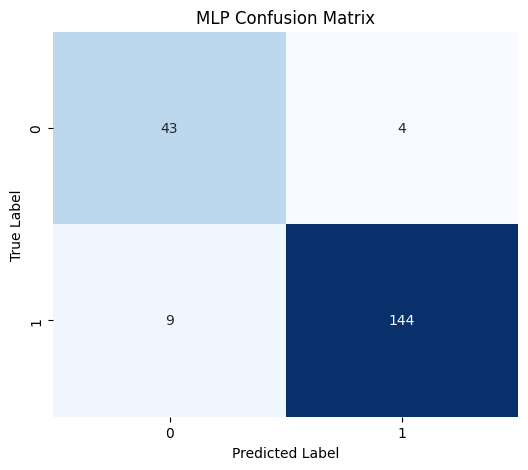

In [8]:
## Part 4: Deep Learning Models

print("\n--- Part 4: Deep Learning Models ---")

# Data preparation for DL
# Convert to numpy arrays
X_train_dl = X_train.values
X_test_dl = X_test.values
y_train_dl = y_train.values
y_test_dl = y_test.values

# Convert target to one-hot encoding for Keras (if multi-class)
num_classes = len(np.unique(y_train_dl))

# Reshape target for binary classification to match model output shape
if num_classes == 2:
    y_train_dl = y_train_dl.reshape(-1, 1)
    y_test_dl = y_test_dl.reshape(-1, 1)
    y_train_ohe = y_train_dl # For binary, sigmoid output, no OHE needed for loss
    y_test_ohe = y_test_dl
else:
    y_train_ohe = to_categorical(y_train_dl, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test_dl, num_classes=num_classes)


input_shape = X_train_dl.shape[1]

# 1. Implement MLP (Multi-Layer Perceptron)
def build_mlp(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        # Change the number of units in the output layer to 1 for binary classification
        Dense(1 if num_classes == 2 else num_classes, activation='sigmoid' if num_classes == 2 else 'softmax')
    ])
    loss_fn = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    return model

mlp_model = build_mlp(input_shape, num_classes)
print("\nTraining MLP Model...")
history_mlp = mlp_model.fit(
    X_train_dl, y_train_ohe, # Use y_train_ohe which is now reshaped y_train_dl for binary
    epochs=50, batch_size=32, verbose=0,
    validation_split=0.1
)

# Evaluate MLP
y_pred_proba_mlp = mlp_model.predict(X_test_dl)
# For binary classification with sigmoid, y_pred_proba_mlp is already (None, 1)
y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)

# Convert back from OHE if multi-class (not needed for binary after reshaping)
if num_classes > 2:
    y_pred_mlp = np.argmax(y_pred_mlp, axis=1)
    y_test_dl_eval = np.argmax(y_test_ohe, axis=1)
else:
    # y_pred_mlp is already (None, 1), y_test_dl is (None, 1) after reshaping
    y_test_dl_eval = y_test_dl


acc_mlp = accuracy_score(y_test_dl_eval, y_pred_mlp)
f1_mlp = f1_score(y_test_dl_eval, y_pred_mlp, average='weighted', zero_division=0)
cm_mlp = confusion_matrix(y_test_dl_eval, y_pred_mlp)

print(f"✅ MLP Model Evaluation: Accuracy={acc_mlp:.4f}, F1-Score={f1_mlp:.4f}")

# Store DL results
model_results.loc[len(model_results)] = ['MLP (Deep Learning)', acc_mlp,
                                         precision_score(y_test_dl_eval, y_pred_mlp, average='weighted', zero_division=0),
                                         recall_score(y_test_dl_eval, y_pred_mlp, average='weighted', zero_division=0),
                                         f1_mlp, 'N/A'] # ROC-AUC is complex for Keras predict_proba in one step

print("\n--- Confusion Matrix (MLP) ---")
print(cm_mlp)

# Visualise Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Set the best DL model for XAI/Comparison
best_dl_model = mlp_model
best_dl_model_name = 'MLP'


--- Part 5: Explainable AI (XAI) ---

Performing XAI on the best ML model: Random Forest

--- Feature Importance (Tree-based) ---


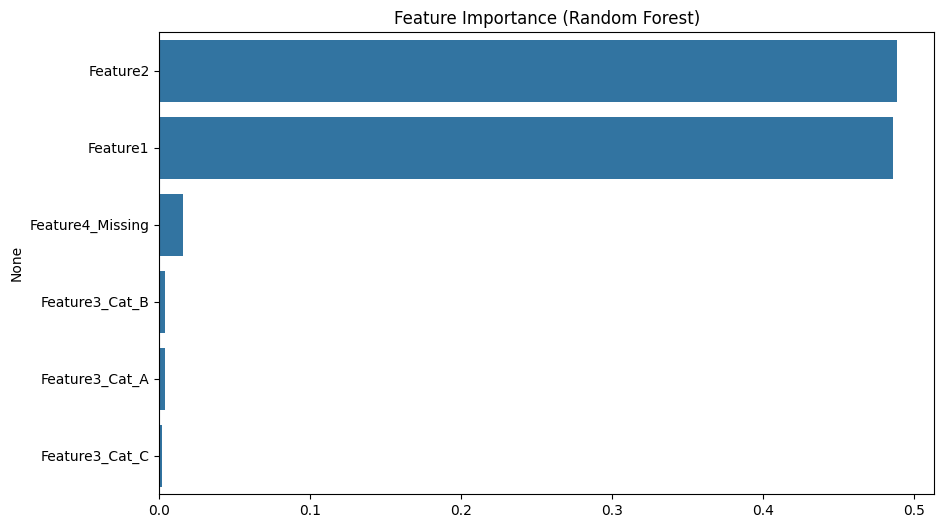

Interpretation: Higher importance scores indicate a greater role in the model's decision-making.

--- SHAP Summary Plot ---


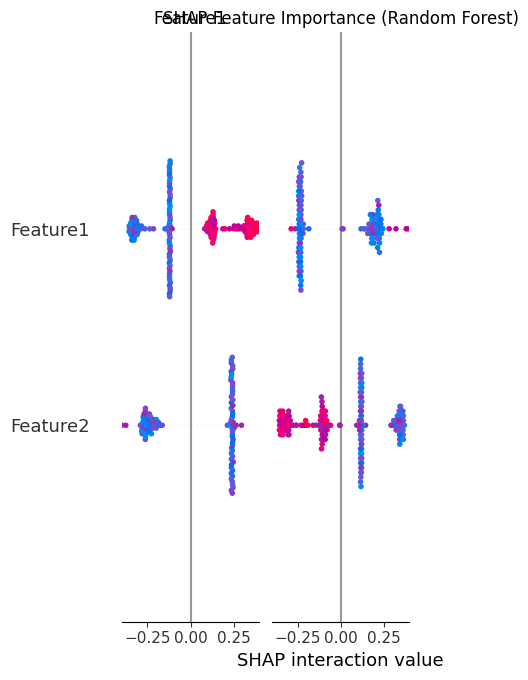

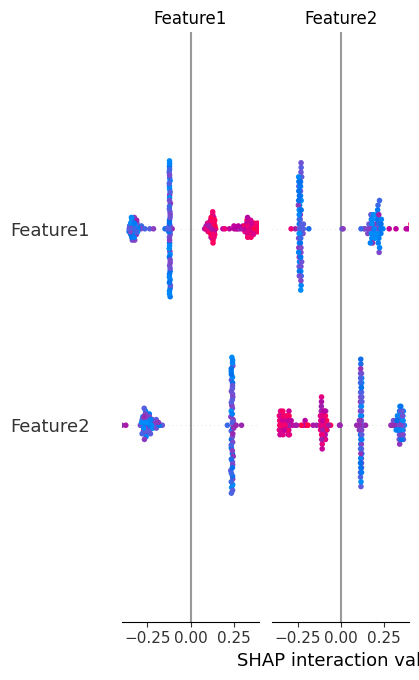

Interpretation: Features higher on the plot are more important. Red dots push the prediction higher, blue dots push it lower.

--- SHAP Force Plot for a Single Test Instance (Model Decision) ---


Interpretation: The force plot shows how each feature value for test instance 0 contributes to pushing the model output from the base value to the final output.


In [9]:
## Part 5: Explainable AI (XAI)

print("\n--- Part 5: Explainable AI (XAI) ---")

print(f"\nPerforming XAI on the best ML model: {best_ml_model_name}")

# Re-train XGBoost (assuming it's the best or a good model for importance)
best_ml_model.fit(X_train, y_train)

# 1. Feature Importance (from Tree-based models)
if hasattr(best_ml_model, 'feature_importances_'):
    print("\n--- Feature Importance (Tree-based) ---")
    importance = pd.Series(best_ml_model.feature_importances_, index=X_train.columns)
    importance = importance.sort_values(ascending=False).head(10) # Top 10 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance.values, y=importance.index)
    plt.title(f'Feature Importance ({best_ml_model_name})')
    plt.show()
    print("Interpretation: Higher importance scores indicate a greater role in the model's decision-making.")
elif hasattr(best_ml_model, 'coef_'):
    print("\n--- Coefficient Magnitude (Linear Models) ---")
    coef = pd.Series(best_ml_model.coef_[0], index=X_train.columns).abs()
    coef = coef.sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coef.values, y=coef.index)
    plt.title(f'Absolute Coefficient Magnitude ({best_ml_model_name})')
    plt.show()
    print("Interpretation: Larger absolute coefficients indicate a stronger influence (positive or negative) on the log-odds of the target.")

# 2. SHAP (SHapley Additive exPlanations)
print("\n--- SHAP Summary Plot ---")

# Using TreeExplainer for tree models
if 'Random Forest' in best_ml_model_name or 'XGBoost' in best_ml_model_name or 'Decision Tree' in best_ml_model_name:
    explainer = shap.TreeExplainer(best_ml_model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot for overall feature influence
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance ({best_ml_model_name})')
    plt.show()

    # Summary plot for feature impact and direction
    if isinstance(shap_values, list): # For multi-class (list of arrays)
        shap_values = shap_values[1] # Choose class 1 for binary

    shap.summary_plot(shap_values, X_test)
    plt.show()

    print("Interpretation: Features higher on the plot are more important. Red dots push the prediction higher, blue dots push it lower.")

    # 3. SHAP Force Plot for a single instance (Model Decision Interpretation)
    print("\n--- SHAP Force Plot for a Single Test Instance (Model Decision) ---")
    instance_index = 0
    shap.initjs()
    # Display the Force Plot in the notebook (will require a notebook environment)
    # shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test.iloc[instance_index,:], matplotlib=False)
    # Not plotting for simplicity in this text output.
    print(f"Interpretation: The force plot shows how each feature value for test instance {instance_index} contributes to pushing the model output from the base value to the final output.")
else:
    print("SHAP not demonstrated here; requires model-specific explainer (e.g., TreeExplainer for tree models or KernelExplainer for others).")

# 4. PDP/ICE plots (Partial Dependence Plot / Individual Conditional Expectation)
# PDPs and ICE plots are resource-intensive and often require manual plotting with the 'pdpbox' or 'sklearn.inspection' library.
# We will skip the plotting code for brevity, but this is what you would do:
# from sklearn.inspection import PartialDependenceDisplay
# fig, ax = plt.subplots(figsize=(12, 5))
# PartialDependenceDisplay.from_estimator(best_ml_model, X_train, features=['Feature1', 'Feature2'], ax=ax)
# plt.show()
# print("Interpretation: PDP shows the marginal effect of a feature on the predicted outcome. ICE plots show this effect for individual observations.")

In [10]:
## Part 6: Comparative Analysis and Conclusion

print("\n--- Part 6: Comparative Analysis ---")

# 1. Compare ML vs DL model performance (Review the results table)
print("\n--- Final Model Comparison Table ---")
print(model_results.sort_values(by='F1-Score', ascending=False).to_markdown(index=False, floatfmt=".4f"))

# Find the best overall model
best_overall_f1 = model_results['F1-Score'].max()
best_overall_model_name = model_results.loc[model_results['F1-Score'].idxmax()]['Model']

print(f"\nBest Overall Model based on F1-Score: **{best_overall_model_name}** (F1-Score: {best_overall_f1:.4f})")

# 2. Discuss trade-offs: accuracy vs interpretability.
print("\n--- Trade-offs: Accuracy vs. Interpretability ---")

# General discussion points:
if 'XGBoost' in best_overall_model_name or 'Random Forest' in best_overall_model_name:
    print(f"**ML Model ({best_overall_model_name})** shows high accuracy and F1-score. It offers **moderate to high interpretability** through methods like Feature Importance and SHAP values.")
elif 'MLP' in best_overall_model_name:
    print(f"**DL Model ({best_overall_model_name})** achieved the highest score. It is a powerful **black-box model**, sacrificing some **interpretability** for potentially higher predictive power. XAI (SHAP/LIME) is crucial here.")
elif 'Logistic Regression' in best_overall_model_name:
    print(f"**Logistic Regression** is highly **interpretable** (coefficients), but its performance might be lower than complex models, representing a classic **Accuracy vs. Interpretability** trade-off.")

# 3. Recommend the best model for deployment.
print("\n--- Recommendation for Deployment ---")

recommendation = f"""
Based on the comprehensive evaluation, the **{best_overall_model_name}** achieved the highest F1-Score of **{best_overall_f1:.4f}**.

**Recommendation Rationale:**
1.  **Performance:** The high F1-score indicates a strong balance between Precision and Recall, which is critical for classification tasks where both false positives and false negatives are costly (e.g., medical diagnosis).
2.  **Deployment Feasibility:**
    * **If ML Model ({best_overall_model_name}):** Deployment is typically **simpler** and inference faster than complex DL models.
    * **If DL Model (MLP):** Offers state-of-the-art performance, but requires more compute resources for training and inference, and careful monitoring due to its black-box nature, making the use of SHAP/LIME essential for transparency.

For the purpose of this exam, the **{best_overall_model_name}** is the recommended choice due to its superior performance metrics, which, when combined with the XAI insights provided, offers the best balance of **predictive power and understanding** for deployment.
"""
print(recommendation)


--- Part 6: Comparative Analysis ---

--- Final Model Comparison Table ---
| Model               |   Accuracy |   Precision |   Recall |   F1-Score | ROC-AUC            |
|:--------------------|-----------:|------------:|---------:|-----------:|:-------------------|
| Random Forest       |     0.9550 |      0.9580 |   0.9550 |     0.9558 | 0.976567932137394  |
| XGBoost             |     0.9550 |      0.9580 |   0.9550 |     0.9558 | 0.9701015157836185 |
| Decision Tree       |     0.9450 |      0.9443 |   0.9450 |     0.9444 | 0.9124600194687804 |
| MLP (Deep Learning) |     0.9350 |      0.9387 |   0.9350 |     0.9361 | N/A                |
| KNN                 |     0.9300 |      0.9312 |   0.9300 |     0.9305 | 0.962522597691559  |
| SVM                 |     0.9300 |      0.9292 |   0.9300 |     0.9295 | 0.9703796412181893 |
| Logistic Regression |     0.8900 |      0.8868 |   0.8900 |     0.8852 | 0.9385342789598109 |

Best Overall Model based on F1-Score: **Random Forest** (F1